# 3 Modeling

## 3.1 Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, count, when, isnan
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
import numpy as np
from itertools import chain
pd.set_option('max_columns', None)

#temporary hide error reports
import warnings
warnings.filterwarnings('ignore')

In [2]:
spark = SparkSession.builder.appName("modelovaniNehod").getOrCreate()

In [3]:
modelData = spark.read.parquet("modelData").selectExpr("label", "features")

In [4]:
modelData.limit(5).toPandas()

,label,features
0,1,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
1,0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ..."
2,0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
3,0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
4,0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."


## 3.2 Subsets

In [5]:
trainData, testData = modelData.randomSplit([0.7, 0.3])

print("trainData count is {}, testDataCount is: {}".format(trainData.count(), testData.count()))

trainData count is 327604, testDataCount is: 140689


## 3.3 Stage

In [42]:
stages = []

# DECISION TREE CLASSIFIER
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", predictionCol="DTprediction", rawPredictionCol="DTRawPrediction", probabilityCol="DTProbability")
stages.append(dt)

# RANDOM FOREST CLASSIFIER
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(labelCol="label", featuresCol="features", predictionCol="RFprediction", rawPredictionCol="RFRawPrediction", probabilityCol="RFProbability", numTrees=10)
stages.append(rf)

# GBT CLASSIFIER
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="label", featuresCol="features", predictionCol="GBTprediction", maxIter=10)
stages.append(gbt)

# LOGISTIC REGRESSION
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="LRprediction", probabilityCol="LRProbability", rawPredictionCol="LRRawPrediction", family="binomial", threshold=0.5)
stages.append(lr)

# NAIVE BAYES
from pyspark.ml.classification import NaiveBayes
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol="features", labelCol="label", predictionCol="NBprediction", probabilityCol="NBProbability", rawPredictionCol="NBRawPprediction")
stages.append(nb)

## 3.4 Pipeline

In [43]:
pipeline = Pipeline(stages = stages)
predictionModel = pipeline.fit(trainData)
predictions = predictionModel.transform(testData)
predictions.createOrReplaceTempView("predictions")

In [44]:
predictions.limit(5).toPandas()

,label,features,DTRawPrediction,DTProbability,DTprediction,RFRawPrediction,RFProbability,RFprediction,rawPrediction,probability,GBTprediction,LRRawPrediction,LRProbability,LRprediction,NBRawPprediction,NBProbability,NBprediction
0,0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[135570.0, 41139.0]","[0.7671935215523827, 0.23280647844761726]",0.0,"[7.960478267123499, 2.0395217328765023]","[0.7960478267123499, 0.20395217328765022]",0.0,"[0.7541448031888751, -0.7541448031888751]","[0.8188075882619448, 0.18119241173805523]",0.0,"[2.0837681106289097, -2.0837681106289097]","[0.8893154859024228, 0.11068451409757715]",0.0,"[-134.47888486105415, -135.64499852310377]","[0.7624418236250924, 0.2375581763749077]",0.0
1,0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[135570.0, 41139.0]","[0.7671935215523827, 0.23280647844761726]",0.0,"[7.960478267123499, 2.0395217328765023]","[0.7960478267123499, 0.20395217328765022]",0.0,"[0.7541448031888751, -0.7541448031888751]","[0.8188075882619448, 0.18119241173805523]",0.0,"[2.2425641539385746, -2.2425641539385746]","[0.9040072015300331, 0.09599279846996693]",0.0,"[-137.98184253354054, -139.12789914245454]","[0.7587899035455822, 0.2412100964544178]",0.0
2,0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[135570.0, 41139.0]","[0.7671935215523827, 0.23280647844761726]",0.0,"[7.960478267123499, 2.0395217328765023]","[0.7960478267123499, 0.20395217328765022]",0.0,"[0.7541448031888751, -0.7541448031888751]","[0.8188075882619448, 0.18119241173805523]",0.0,"[2.2425641539385746, -2.2425641539385746]","[0.9040072015300331, 0.09599279846996693]",0.0,"[-137.98184253354054, -139.12789914245454]","[0.7587899035455822, 0.2412100964544178]",0.0
3,0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[135570.0, 41139.0]","[0.7671935215523827, 0.23280647844761726]",0.0,"[7.960478267123499, 2.0395217328765023]","[0.7960478267123499, 0.20395217328765022]",0.0,"[0.7541448031888751, -0.7541448031888751]","[0.8188075882619448, 0.18119241173805523]",0.0,"[2.4153486767404164, -2.4153486767404164]","[0.9179902537436024, 0.08200974625639752]",0.0,"[-138.16081708346212, -139.45817592135396]","[0.7853901442182522, 0.21460985578174785]",0.0
4,0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[135570.0, 41139.0]","[0.7671935215523827, 0.23280647844761726]",0.0,"[7.960478267123499, 2.0395217328765023]","[0.7960478267123499, 0.20395217328765022]",0.0,"[0.7541448031888751, -0.7541448031888751]","[0.8188075882619448, 0.18119241173805523]",0.0,"[2.0191341710633033, -2.0191341710633033]","[0.8827914508816705, 0.11720854911832945]",0.0,"[-138.56886839499757, -139.34654649453566]","[0.6851794756124814, 0.3148205243875186]",0.0


## 3.5 Print the coefficients and trees

### 3.5.1 Logistic regression coefficients

In [45]:
lrModel = lr.fit(trainData)
intercept = lrModel.intercept

In [46]:
lrPrediction = lrModel.transform(testData)

In [47]:
from itertools import chain

attrs = sorted((attr["idx"], attr["name"]) for attr in 
               (chain(*lrPrediction.schema["features"].metadata["ml_attr"]["attrs"].values())
               )
              )

pairs = [(name, lrModel.coefficients[idx]) for idx, name in attrs]

import numpy as np

sorted_pairs = sorted(pairs, key = lambda p: abs(p[1]), reverse=True)
variables = [("intercept", intercept)] + sorted_pairs

results = pd.DataFrame(variables, columns = ["predictors", "coefficients"])

In [39]:
pd.set_option('display.max_rows', None)
results.sort_values('coefficients', ascending=False)

,predictors,coefficients
1,DRUH_NEHODY_oh_srážka s chodcem,5.344105
5,ZAVINĚNÍ_NEHODY_oh_řidičem nemotorového vozidla,2.437363
6,SITUOVÁNÍ_NEHODY_NA_KOMUNIKACI_oh_chůze po ne...,2.423277
7,ROZHLEDOVÉ_POMĚRY_oh_výhled zakryt stojícím vo...,2.135748
9,VNĚJŠÍ_OVLIVNĚNÍ_ŘIDIČE_oh_oslnen sluncem,1.991633
10,ROZHLEDOVÉ_POMĚRY_oh_jiné špatné,1.923700
14,ROZHLEDOVÉ_POMĚRY_oh_špatné vlivem vegetace - ...,1.604805
15,ROZHLEDOVÉ_POMĚRY_oh_dobré,1.586984
16,DRUH_NEHODY_oh_jiný druh nehody,1.575027
17,ROZHLEDOVÉ_POMĚRY_oh_špatné vlivem okolní zást...,1.565519


In [13]:
# export Logit coefficients to csv (for visualization)
results.to_csv('lrCoefficients.csv')

### 3.5.2 Decision tree

In [14]:
treeModel = dt.fit(testData)
print(treeModel.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_28e3a49ca62f) of depth 5 with 35 nodes
  If (feature 104 in {1.0})
   If (feature 130 in {1.0})
    If (feature 8 in {1.0})
     If (feature 161 in {1.0})
      If (feature 35 in {1.0})
       Predict: 0.0
      Else (feature 35 not in {1.0})
       Predict: 1.0
     Else (feature 161 not in {1.0})
      If (feature 18 in {1.0})
       Predict: 0.0
      Else (feature 18 not in {1.0})
       Predict: 1.0
    Else (feature 8 not in {1.0})
     If (feature 147 in {1.0})
      If (feature 10 in {0.0})
       Predict: 0.0
      Else (feature 10 not in {0.0})
       Predict: 1.0
     Else (feature 147 not in {1.0})
      If (feature 117 in {1.0})
       Predict: 0.0
      Else (feature 117 not in {1.0})
       Predict: 1.0
   Else (feature 130 not in {1.0})
    If (feature 141 in {0.0})
     If (feature 56 in {1.0})
      Predict: 0.0
     Else (feature 56 not in {1.0})
      Predict: 1.0
    Else (feature 141 not in {0.0})
     Pr

### 3.5.3 Random forests

In [18]:
rfModel = rf.fit(testData)
print(rfModel.toDebugString)

RandomForestClassificationModel (uid=RandomForestClassifier_1defcfb00d6c) with 10 trees
  Tree 0 (weight 1.0):
    If (feature 2 <= 0.7233277630270138)
     If (feature 149 in {1.0})
      If (feature 57 in {0.0})
       If (feature 161 in {0.0})
        If (feature 170 in {0.0})
         Predict: 0.0
        Else (feature 170 not in {0.0})
         Predict: 1.0
       Else (feature 161 not in {0.0})
        Predict: 0.0
      Else (feature 57 not in {0.0})
       If (feature 23 in {0.0})
        Predict: 0.0
       Else (feature 23 not in {0.0})
        If (feature 101 in {1.0})
         Predict: 0.0
        Else (feature 101 not in {1.0})
         Predict: 1.0
     Else (feature 149 not in {1.0})
      Predict: 0.0
    Else (feature 2 > 0.7233277630270138)
     Predict: 1.0
  Tree 1 (weight 1.0):
    If (feature 42 in {1.0})
     If (feature 7 in {1.0})
      If (feature 2 <= 0.7233277630270138)
       Predict: 0.0
      Else (feature 2 > 0.7233277630270138)
       Predict: 1.0
     

### 3.5.4 Gradient boosted tree

In [19]:
gbtModel = gbt.fit(trainData)
print(gbtModel.toDebugString)

GBTClassificationModel (uid=GBTClassifier_5dc7a7bfd9e7) with 10 trees
  Tree 0 (weight 1.0):
    If (feature 2 <= 0.7233277630270138)
     If (feature 1 <= 3.403313758174694)
      If (feature 0 <= 6.777901014488855)
       Predict: -1.0
      Else (feature 0 > 6.777901014488855)
       Predict: 1.0
     Else (feature 1 > 3.403313758174694)
      Predict: 1.0
    Else (feature 2 > 0.7233277630270138)
     Predict: 1.0
  Tree 1 (weight 0.1):
    If (feature 2 <= -0.2554261390912864)
     If (feature 1 <= -0.07193706104772389)
      If (feature 0 <= -0.03668591112962441)
       If (feature 5 <= 1.3418406115441774)
        If (feature 48 in {0.0})
         Predict: -0.47681168808860885
        Else (feature 48 not in {0.0})
         Predict: -0.4768116880882528
       Else (feature 5 > 1.3418406115441774)
        If (feature 67 in {0.0})
         Predict: -0.4768116880884589
        Else (feature 67 not in {0.0})
         Predict: -0.4768116880884531
      Else (feature 0 > -0.03668591112

## 3.6 Binary classification evaluator

In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# DECISION TREE
dtEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label", rawPredictionCol="DTRawPrediction")
print("DECISION TREE Area under ROC: " + str(dtEvaluator.evaluate(predictions)))

#RANDOM FOREST
rfEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label", rawPredictionCol="RFRawPrediction")
print("RANDOM FOREST Area under ROC: " + str(rfEvaluator.evaluate(predictions)))

#GBT
gbtEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label", rawPredictionCol="rawPrediction")
print("GBT Area under ROC: " + str(gbtEvaluator.evaluate(predictions)))

#LOGISTIC REGRESSION
blrEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label", rawPredictionCol="LRRawPrediction")
print("LOGISTIC REGRESSION Area under ROC: " + str(blrEvaluator.evaluate(predictions)))

#NAIVE BAYES
nbEvaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol="label", rawPredictionCol="NBprediction")
print("NAIVE BAYES Area under ROC: " + str(nbEvaluator.evaluate(predictions)))

DECISION TREE Area under ROC: 0.6030471193727109
RANDOM FOREST Area under ROC: 0.8635932161985542
GBT Area under ROC: 0.8981134828142829
LOGISTIC REGRESSION Area under ROC: 0.9139872701825695
NAIVE BAYES Area under ROC: 0.7712670435026981


### 3.6.1 Logit metrics

In [41]:
# create summary for logit and calculate Accuracy and TPR
trainingSummary = lrModel.summary

accuracy = trainingSummary.accuracy #correctly predicted TP + TN
truePositiveRate = trainingSummary.weightedTruePositiveRate #correctly predicted TN
print("Accuracy: %s\nTPR (Recall/Sensitivity): %s"
      % (accuracy, truePositiveRate))

Accuracy: 0.8792841357248385
TPR (Recall/Sensitivity): 0.8792841357248385


## 3.7 Cross validation and other metrics

### (Not used)

In [18]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

blrPipeline = Pipeline(stages = [lr])

blrParamGrid = ParamGridBuilder() \
    .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.5, 0.9, 1.0])\
    .addGrid(lr.regParam, [0.0, 0.5, 0.9])\
    .addGrid(lr.maxIter, [50]).build()
    
blrCrossValidator = CrossValidator(estimator=blrPipeline,
                          estimatorParamMaps=blrParamGrid,
                          evaluator=blrEvaluator,
                          numFolds=2,
                         parallelism=3)

In [19]:
blrCrossValidatorModel = blrCrossValidator.fit(modelData)

In [20]:
l1 = len(blrParamGrid[0].keys()) 
paramName = []

for i in range(0,l1):
  paramName.append(list(blrParamGrid[0].keys())[i].name)

print(paramName)

['elasticNetParam', 'regParam', 'maxIter']


In [21]:
l2 = len(blrParamGrid)
paramValues = []

for i in range(0,l2):
  paramValues.append(blrParamGrid[i].values())

print(paramValues)

[dict_values([0.0, 0.0, 50]), dict_values([0.0, 0.5, 50]), dict_values([0.0, 0.9, 50]), dict_values([0.1, 0.0, 50]), dict_values([0.1, 0.5, 50]), dict_values([0.1, 0.9, 50]), dict_values([0.5, 0.0, 50]), dict_values([0.5, 0.5, 50]), dict_values([0.5, 0.9, 50]), dict_values([0.9, 0.0, 50]), dict_values([0.9, 0.5, 50]), dict_values([0.9, 0.9, 50]), dict_values([1.0, 0.0, 50]), dict_values([1.0, 0.5, 50]), dict_values([1.0, 0.9, 50])]


In [22]:
allBlrModels = pd.DataFrame.from_records(paramValues, columns =paramName )

metricName = blrEvaluator.getMetricName()
allBlrModels.loc[:,metricName] = blrCrossValidatorModel.avgMetrics

allBlrModels

,elasticNetParam,regParam,maxIter,areaUnderROC
0,0.0,0.0,50,0.913691
1,0.0,0.5,50,0.885230
2,0.0,0.9,50,0.877250
3,0.1,0.0,50,0.913691
4,0.1,0.5,50,0.850549
5,0.1,0.9,50,0.784078
6,0.5,0.0,50,0.913691
7,0.5,0.5,50,0.500000
8,0.5,0.9,50,0.500000
9,0.9,0.0,50,0.913691


In [23]:
bestBlrModel = blrCrossValidatorModel.bestModel
bestBlrModelI = bestBlrModel.stages[-1]
bestBlrModel.transform(testData)

DataFrame[label: int, features: vector, LRRawPrediction: vector, LRProbability: vector, LRprediction: double]

In [24]:
intercept = bestBlrModelI.intercept
intercept

-1.4210933056043655

In [25]:
FPR = list(chain(*bestBlrModel.stages[-1].summary.roc.select("FPR").toPandas().values))
TPR = list(chain(*bestBlrModel.stages[-1].summary.roc.select("TPR").toPandas().values))

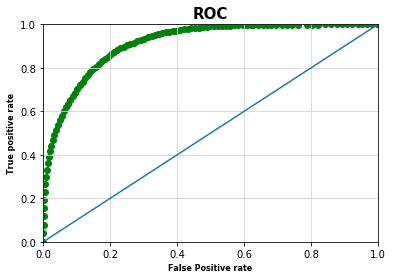

In [26]:
def plotROC(x, y):
    plt.scatter(x, y, color = "#00800D")
    #plt.axis("off")
    plt.title(r'ROC', fontsize=15, weight = 'bold')
    plt.xlabel("False Positive rate", color = 'black',  fontsize=8, weight = 'bold')
    plt.ylabel("True positive rate", color = 'black',  fontsize=8, weight = 'bold')
    plt.grid(True, color = 'lightgrey')
    plt.axis([0, 1, 0, 1])
    plt.viridis()

    x1=[0,1]
    y1=[0,1]
    plt.plot(x1,y1)
    plt.show()
    return; 

plotROC(FPR, TPR)

In [27]:
blrResults = bestBlrModel.transform(modelData)

In [28]:
blrResultMatrix = blrResults\
                  .orderBy(col("label").desc())\
                  .groupBy("label")\
                  .pivot("lrPrediction" , [1.0, 0.0])\
                  .count()
        
display(blrResultMatrix.toPandas())

,label,1.0,0.0
0,1,44442,42087
1,0,14500,367264
